# Key Microstructural Models - Code Examples
This notebook provides simple Python examples illustrating the core concepts from the "Key Microstructural Models" presentation.

Basic imports

In [2]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
mu = 100.0      # Prior expected value E[v]
lambda_kyle = 0.1 # Assumed Kyle's Lambda (measure of illiquidity)
n_simulations = 10_000 # Number of hypothetical auction rounds to simulate

In [4]:
simulated_omega = np.random.normal(0, 50, n_simulations) # Total order flow (e.g., net shares bought/sold)

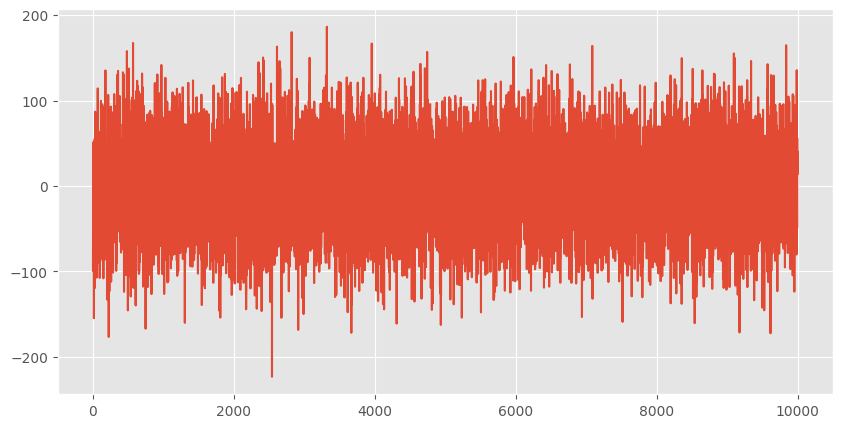

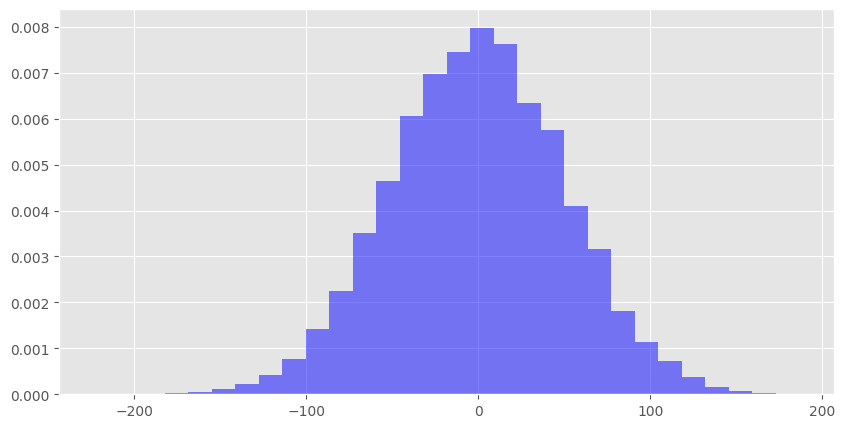

In [5]:
plt.plot(simulated_omega);
plt.show()
plt.hist(simulated_omega, bins=30, density=True, alpha=0.5, color='blue');

In [6]:
simulated_prices = mu + lambda_kyle * simulated_omega

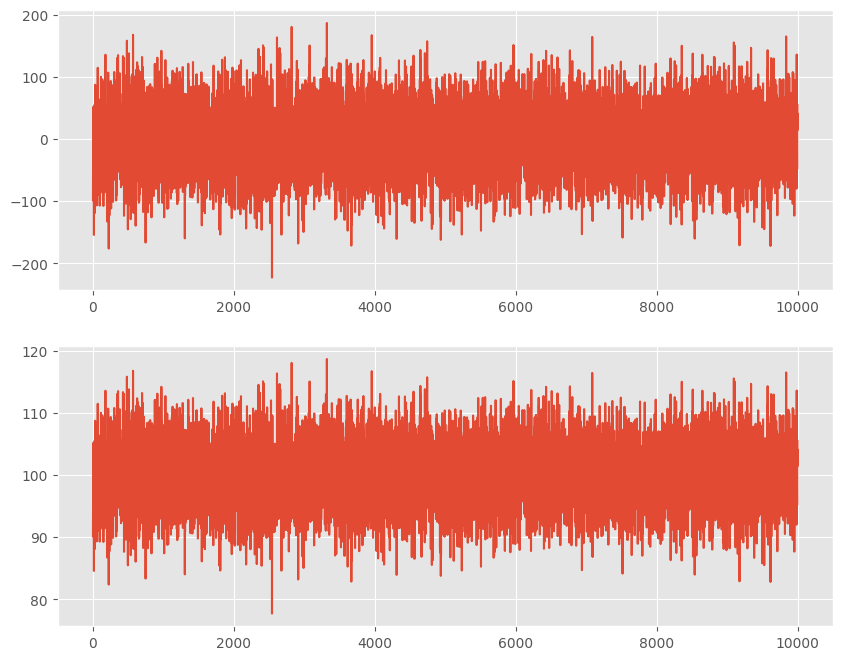

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(simulated_omega)
axes[1].plot(simulated_prices)

In [8]:
results_kyle = pd.DataFrame({
    'Total Order Flow (omega)': simulated_omega,
    'Price (p)': simulated_prices
})
print("Kyle Model Simulation Results (Fixed Lambda):")
print(results_kyle.head())

Kyle Model Simulation Results (Fixed Lambda):
   Total Order Flow (omega)   Price (p)
0                -99.028598   90.097140
1                -52.749282   94.725072
2                -29.351420   97.064858
3                  7.483446  100.748345
4                 51.208116  105.120812


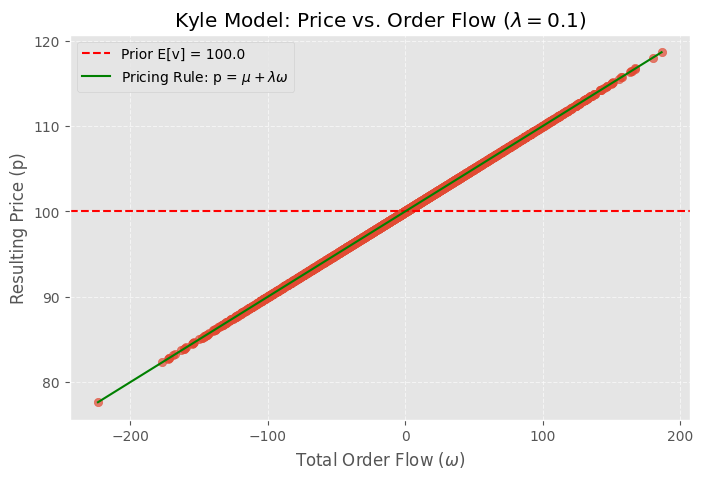

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(results_kyle['Total Order Flow (omega)'], results_kyle['Price (p)'], alpha=0.7)
plt.axhline(mu, color='red', linestyle='--', label=f'Prior E[v] = {mu}')
plt.xlabel('Total Order Flow ($\omega$)')
plt.ylabel('Resulting Price (p)')
plt.title(f'Kyle Model: Price vs. Order Flow ($\lambda = {lambda_kyle}$)')
# Plot the pricing rule line
omega_range = np.linspace(results_kyle['Total Order Flow (omega)'].min(), results_kyle['Total Order Flow (omega)'].max(), 50)
price_line = mu + lambda_kyle * omega_range
plt.plot(omega_range, price_line, color='green', label='Pricing Rule: p = $\mu + \lambda \omega$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Kyle Model - Exercises:**

1.  **Change Lambda:** Rerun the Kyle simulation with a higher and a lower value for `lambda_kyle`. How does the slope of the price vs. order flow relationship change? What does this imply about market liquidity in each case?
2.  **Qualitative Dependencies:** Kyle's model shows that $\lambda$ depends on the variance of noise trades ($Var(u)$) and the variance of the true value / information asymmetry ($Var(v)$).
    * If noise trading *increases* (higher $Var(u)$), would you expect $\lambda$ to increase or decrease? Why? (Hint: How easily can the informed trader hide?)
    * If information asymmetry *increases* (higher $Var(v)$), would you expect $\lambda$ to increase or decrease? Why? (Hint: How much risk does the market maker face from the informed trader?)
3.  **Informed Trader's Perspective (Conceptual):** Imagine you are the informed trader and know the true value `v` will be 105, while `mu` is 100. You want to buy (`x > 0`). If `lambda` is very high, would you trade aggressively (large `x`) or cautiously (small `x`)? Why?

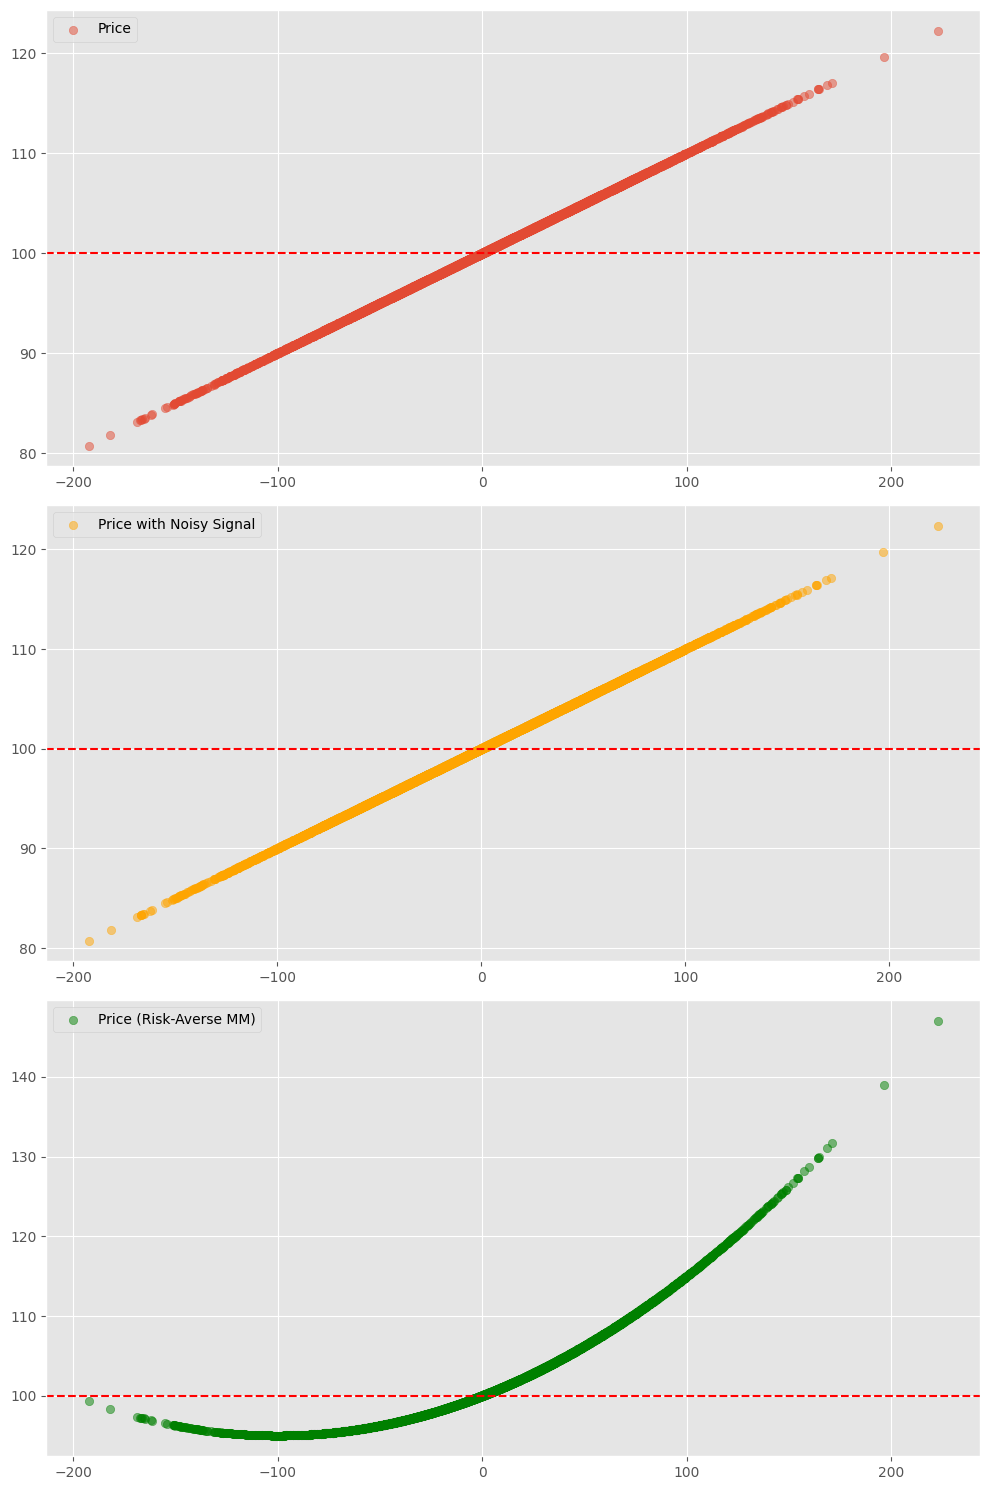

In [11]:
np.random.seed(42)

mu = 100.0  # Prior expected value E[v]
lambda_kyle = 0.1  # Kyle's lambda (price impact)
n_simulations = 10_000  # Number of rounds

n_informed = 3
beta_values = np.array([0.015, 0.02, 0.025])  # trading aggressiveness for each trader

v_true = np.random.normal(mu, 10, n_simulations)
x_total = np.sum([beta * (v_true - mu) for beta in beta_values], axis=0)
u = np.random.normal(0, 50, n_simulations)
omega = x_total + u
prices_multi = mu + lambda_kyle * omega

beta = 0.02
epsilon = np.random.normal(0, 5, n_simulations)
v_signal = v_true + epsilon
x_noisy = beta * (v_signal - mu)
omega_noisy = x_noisy + u
prices_noisy = mu + lambda_kyle * omega_noisy

gamma = 0.0005
prices_risk_averse = mu + lambda_kyle * omega + gamma * omega**2

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].scatter(omega, prices_multi, alpha=0.5, label='Price')
axs[0].axhline(mu, color='red', linestyle='--')
axs[0].grid(True)
axs[0].legend()

axs[1].scatter(omega_noisy, prices_noisy, alpha=0.5, color='orange', label='Price with Noisy Signal')
axs[1].axhline(mu, color='red', linestyle='--')
axs[1].grid(True)
axs[1].legend()

axs[2].scatter(omega, prices_risk_averse, alpha=0.5, color='green', label='Price (Risk-Averse MM)')
axs[2].axhline(mu, color='red', linestyle='--')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


In [12]:
import seaborn as sns
from scipy.optimize import minimize_scalar

SIG_V = 2.0

def LAM_0_HAT(BET_0, SIG_NZ, SIG_EP):
    SIG_S = np.sqrt(SIG_V**2 + SIG_EP**2)
    A = BET_0 * SIG_V**2
    B = SIG_NZ**2 + BET_0**2 * SIG_S**2
    return A / B

def SIG_V_COND_HAT(BET_0, SIG_NZ, SIG_EP):
    SIG_S = np.sqrt(SIG_V**2 + SIG_EP**2)
    A = BET_0**2 * SIG_EP**2 + SIG_NZ**2
    B = BET_0**2 * SIG_S**2 + SIG_NZ**2
    return np.sqrt((A / B) * SIG_V**2)

def SIG_S_COND_HAT(BET_0, SIG_NZ, SIG_EP):
    SIG_S = np.sqrt(SIG_V**2 + SIG_EP**2)
    A = SIG_NZ**2
    B = BET_0**2 * SIG_S**2 + SIG_NZ**2
    return np.sqrt((A / B) * SIG_S**2)

def LAM_1_HAT(BET_0, SIG_NZ, SIG_EP):
    SIG_S = np.sqrt(SIG_V**2 + SIG_EP**2)
    TET = SIG_V**2 / SIG_S**2
    sv_hat = SIG_V_COND_HAT(BET_0, SIG_NZ, SIG_EP)
    ss_hat = SIG_S_COND_HAT(BET_0, SIG_NZ, SIG_EP)
    A = np.sqrt((TET / 2) * (sv_hat**2 - (TET / 2) * ss_hat**2))
    return (1 / SIG_NZ) * A

def BET_0_SLN(BET_0, SIG_NZ, SIG_EP):
    SIG_S = np.sqrt(SIG_V**2 + SIG_EP**2)
    TET = SIG_V**2 / SIG_S**2

    lam0 = LAM_0_HAT(BET_0, SIG_NZ, SIG_EP)
    lam1 = LAM_1_HAT(BET_0, SIG_NZ, SIG_EP)
    omg1 = 1 / (4 * lam1)

    A = TET / (2 * lam0)
    B = lam1 - 2 * omg1 * lam0
    C = lam1 - omg1 * lam0

    ERR = (A * B / C - BET_0) ** 2
    return ERR

In [13]:
SIG_NZ_list = [0.5, 1.0, 1.5] #, 2.0, 5., 10, 50]
SIG_EP_list = np.arange(0.01, 5.01, 0.01)

records = []

for SIG_NZ in SIG_NZ_list:
    for SIG_EP in SIG_EP_list:
        upper_bound = min(1 / (2 * SIG_EP), 0.5)

        result = minimize_scalar(
            BET_0_SLN, bounds=(0, upper_bound), method='bounded',
            args=(SIG_NZ, SIG_EP), options={'xatol': 1e-4}
        )

        if result.fun <= 1e-4:
            BET_0_opt = result.x
            lam0 = LAM_0_HAT(BET_0_opt, SIG_NZ, SIG_EP)
            lam1 = LAM_1_HAT(BET_0_opt, SIG_NZ, SIG_EP)
            TET = SIG_V**2 / (SIG_V**2 + SIG_EP**2)
            BET_1 = TET / (2 * lam1)

            records.append({
                'sigNZ': SIG_NZ,
                'sigEP': SIG_EP,
                'bet0': BET_0_opt,
                'lam0': lam0,
                'lam1': lam1,
                'bet1': BET_1
            })

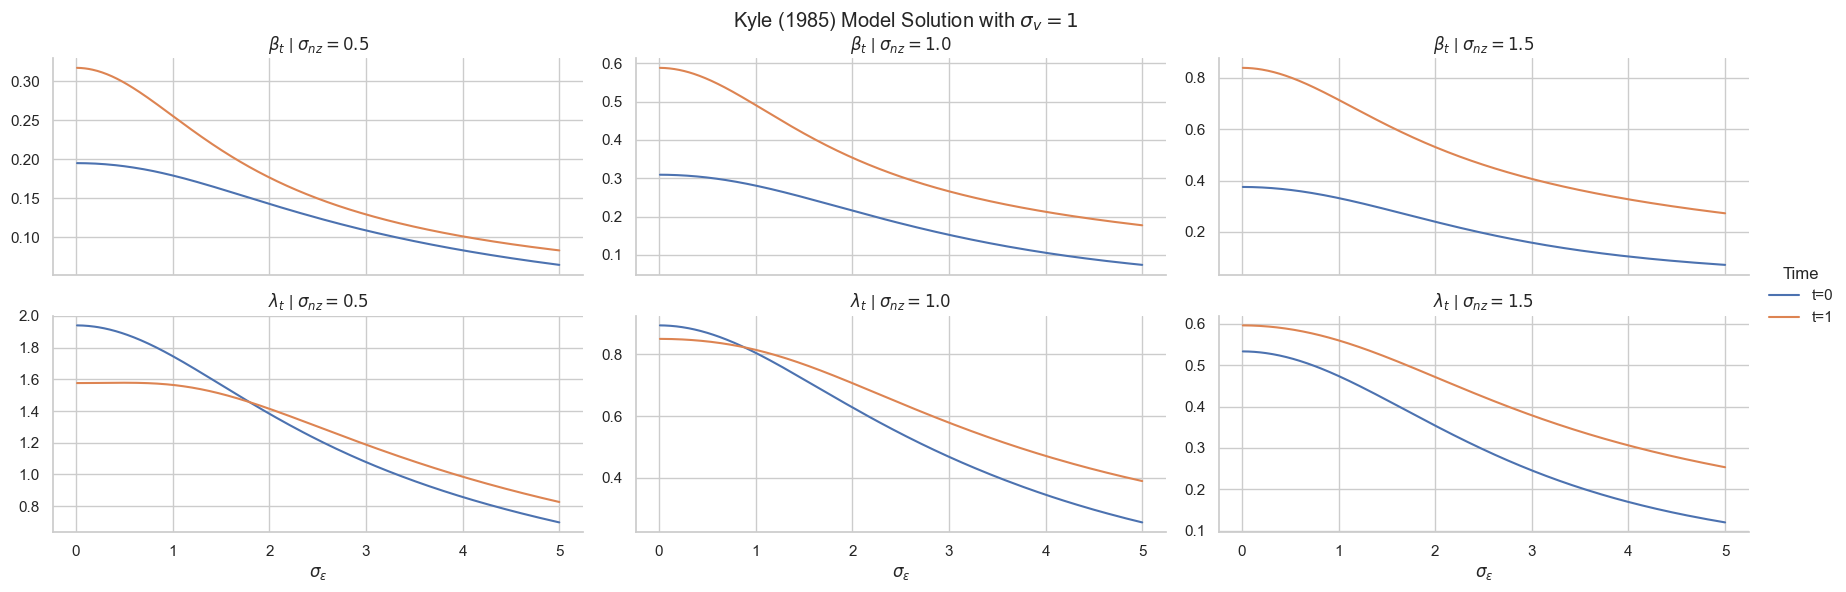

In [14]:
df = pd.DataFrame(records)
df_melted = df.melt(id_vars=['sigNZ', 'sigEP'], value_vars=['bet0', 'bet1', 'lam0', 'lam1'], var_name='variable')

df_melted['time'] = df_melted['variable'].apply(lambda v: 't=0' if v in ['bet0', 'lam0'] else 't=1')
df_melted['coef'] = df_melted['variable'].apply(lambda v: r'$\beta_t$' if 'bet' in v else r'$\lambda_t$')

sns.set_theme(style='whitegrid')
g = sns.FacetGrid(df_melted, col='sigNZ', row='coef', hue='time', sharey=False, height=3, aspect=2)

g.map_dataframe(sns.lineplot, x='sigEP', y='value')

g.set_axis_labels(r'$\sigma_{\epsilon}$', '')
g.set_titles(row_template="{row_name}", col_template=r"$\sigma_{{nz}} = {col_name}$")
g.add_legend(title="Time")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Kyle (1985) Model Solution with $\sigma_v = 1$")
plt.show()
